In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import warnings
warnings.filterwarnings('ignore')


plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 1. 数据加载与预处理
def load_electricity_data(file_path):
    # 读取数据，指定日期列为索引
    df = pd.read_csv(file_path, parse_dates=['date'], index_col='date')
    
    # 重命名列：0-319为客户，最后一列为OT（目标变量）
    df.columns = [f'client_{i}' if i < 320 else 'OT' for i in range(len(df.columns))]
    print(f"数据集形状: {df.shape}")
    print(f"时间范围: {df.index.min()} 到 {df.index.max()}")
    print(f"缺失值数量: {df.isnull().sum().sum()}")
    
    return df


数据集形状: (26304, 321)
时间范围: 2016-07-01 02:00:00 到 2019-07-02 01:00:00
缺失值数量: 0

目标变量(OT)统计描述:
count    26304.000000
mean      3335.883744
std        552.754335
min          0.000000
25%       2920.000000
50%       3271.000000
75%       3632.000000
max       6035.000000
Name: OT, dtype: float64


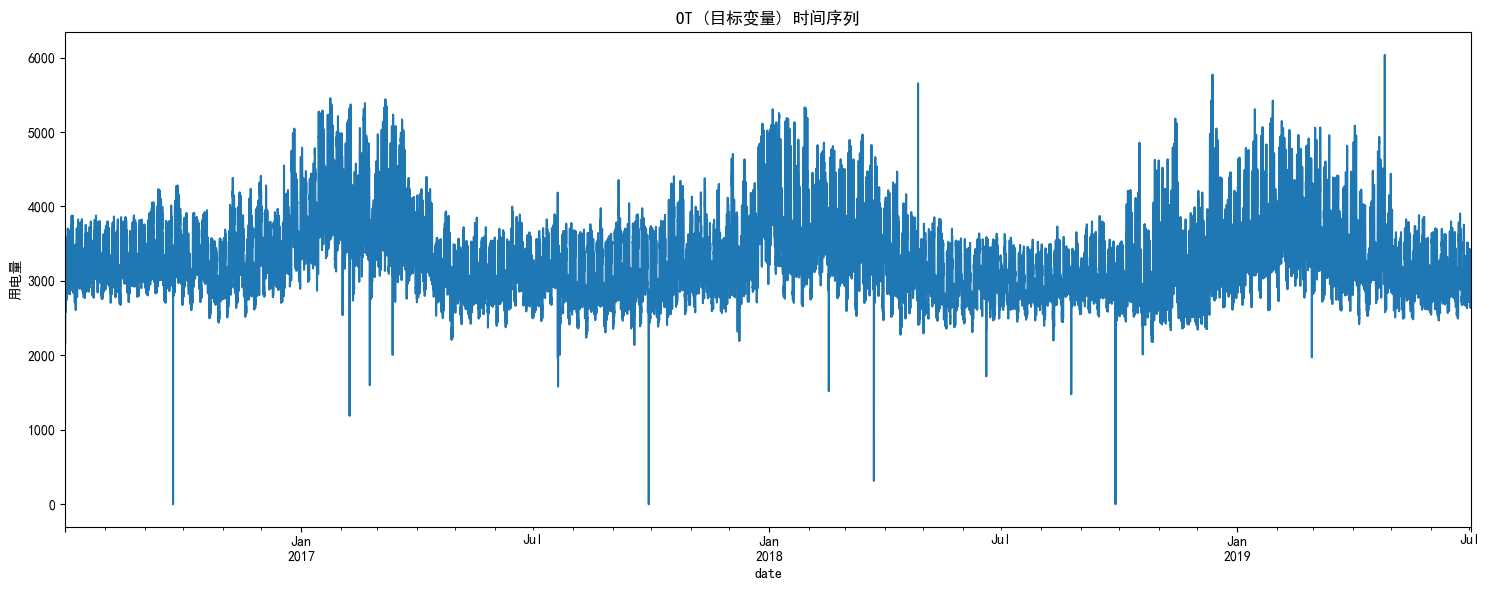

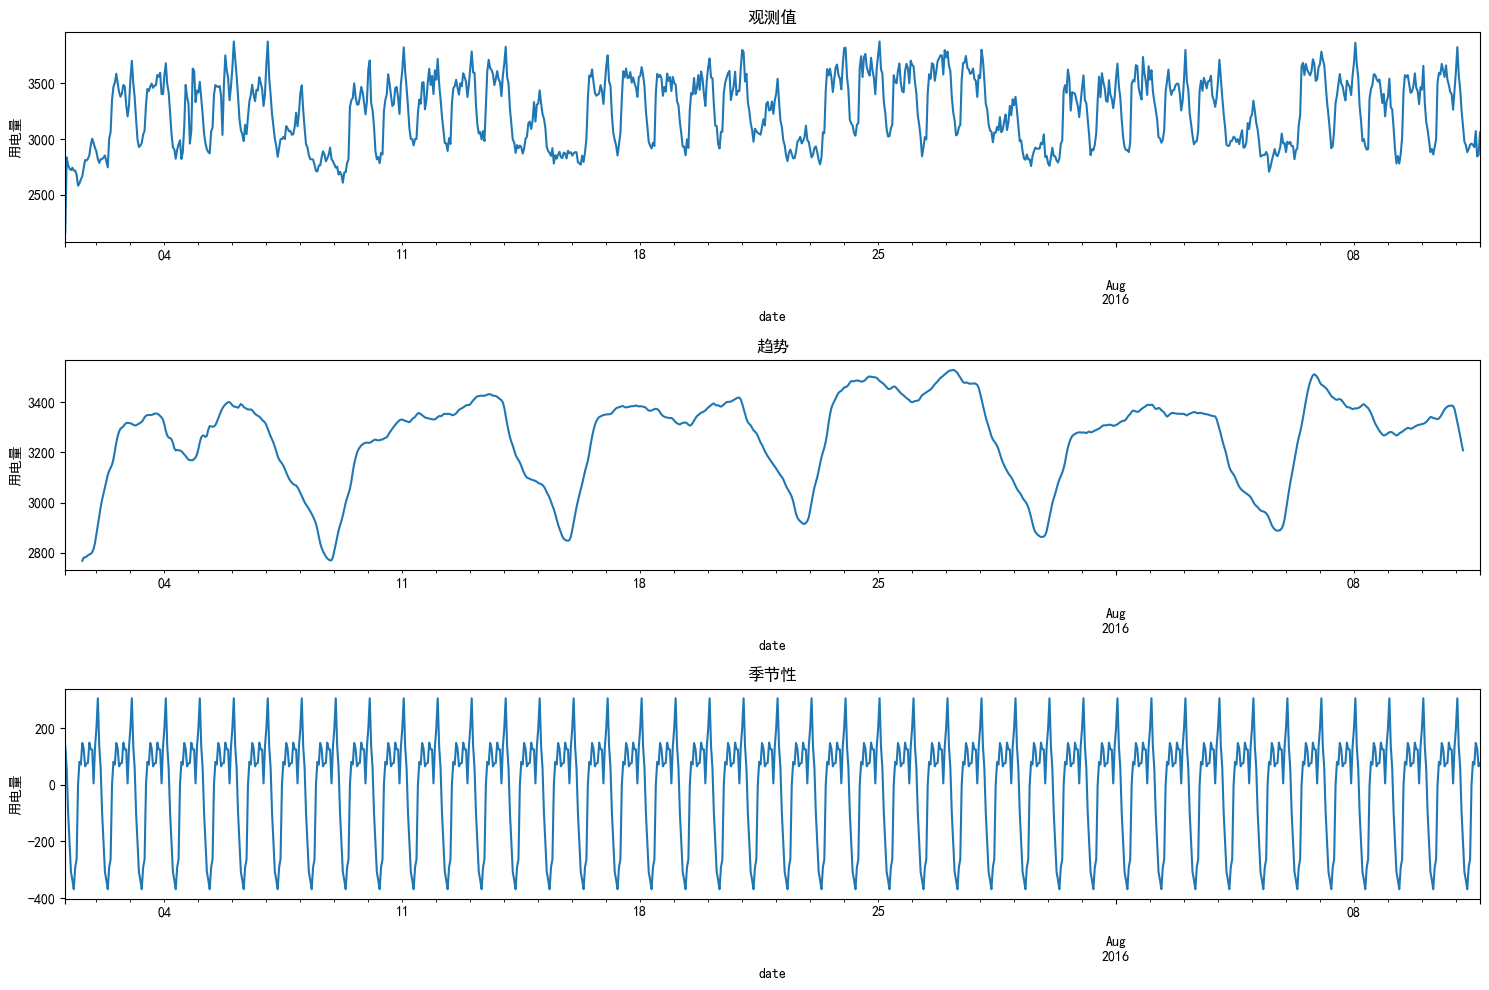


选择的代表性客户:
高相关性客户: client_119 (相关性: 0.7091)
中等相关性客户: client_198 (相关性: 0.4720)
低相关性客户: client_105 (相关性: -0.5084)


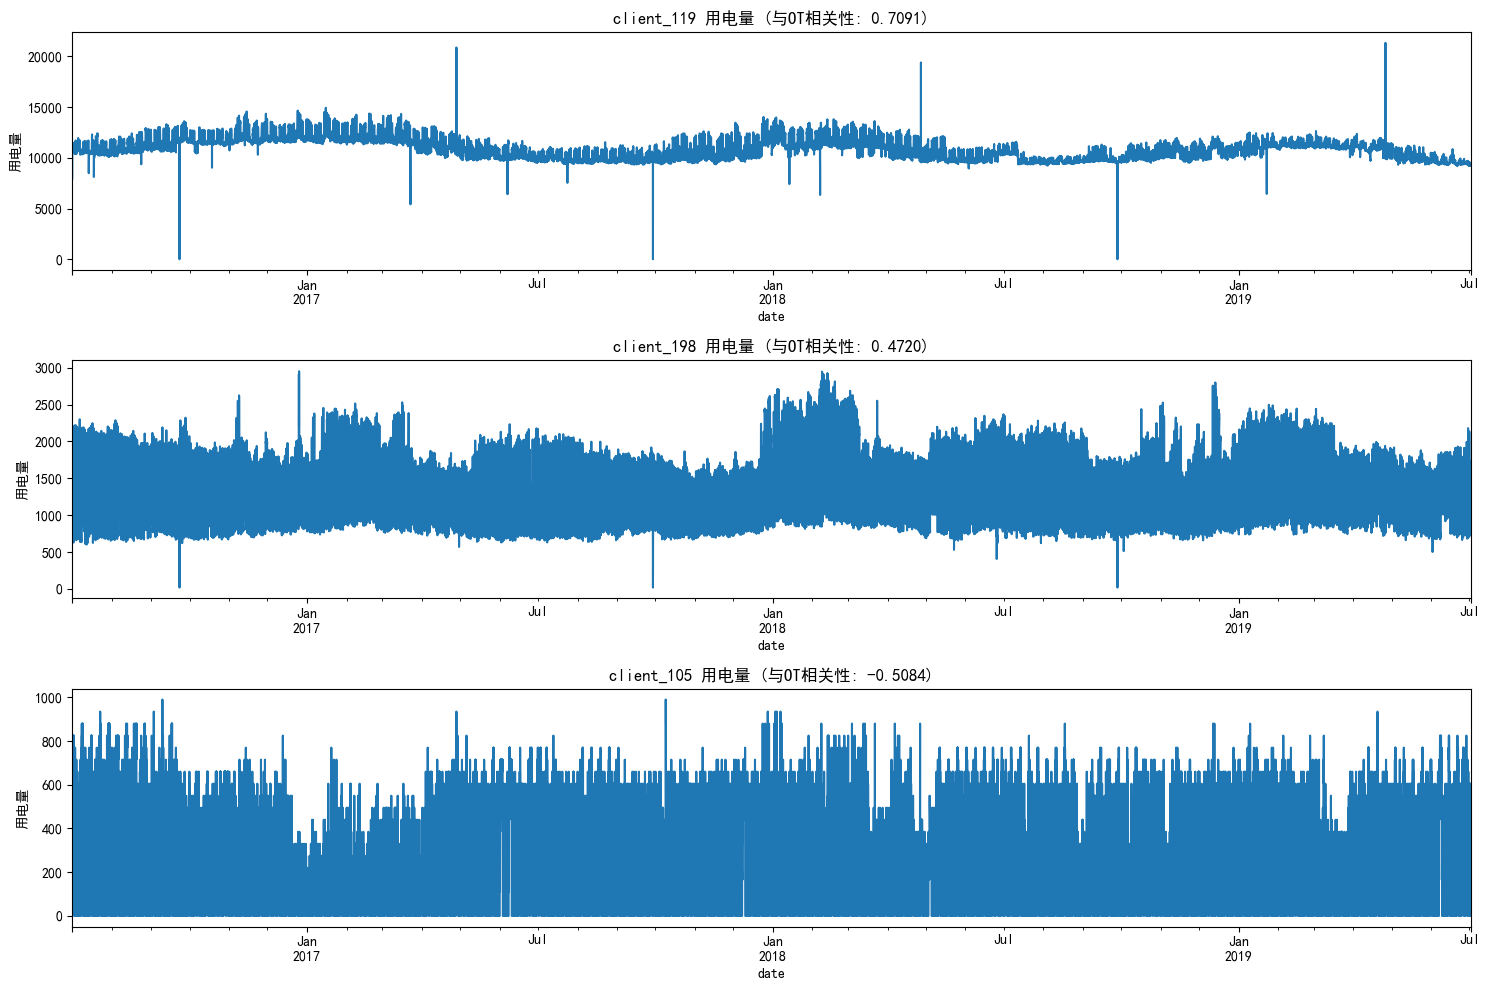

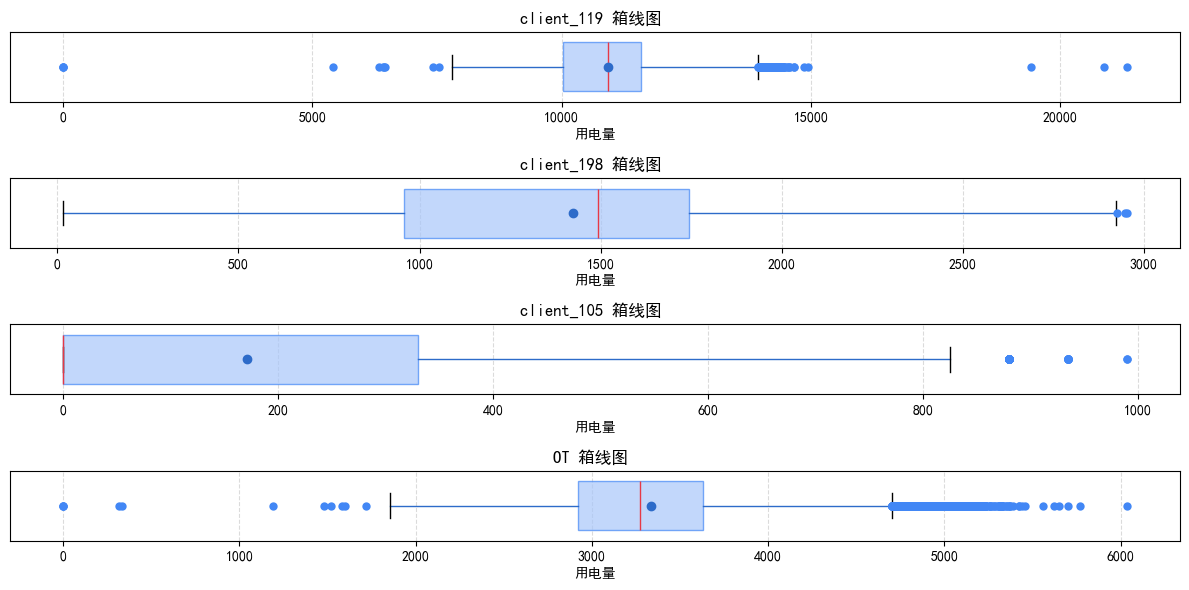

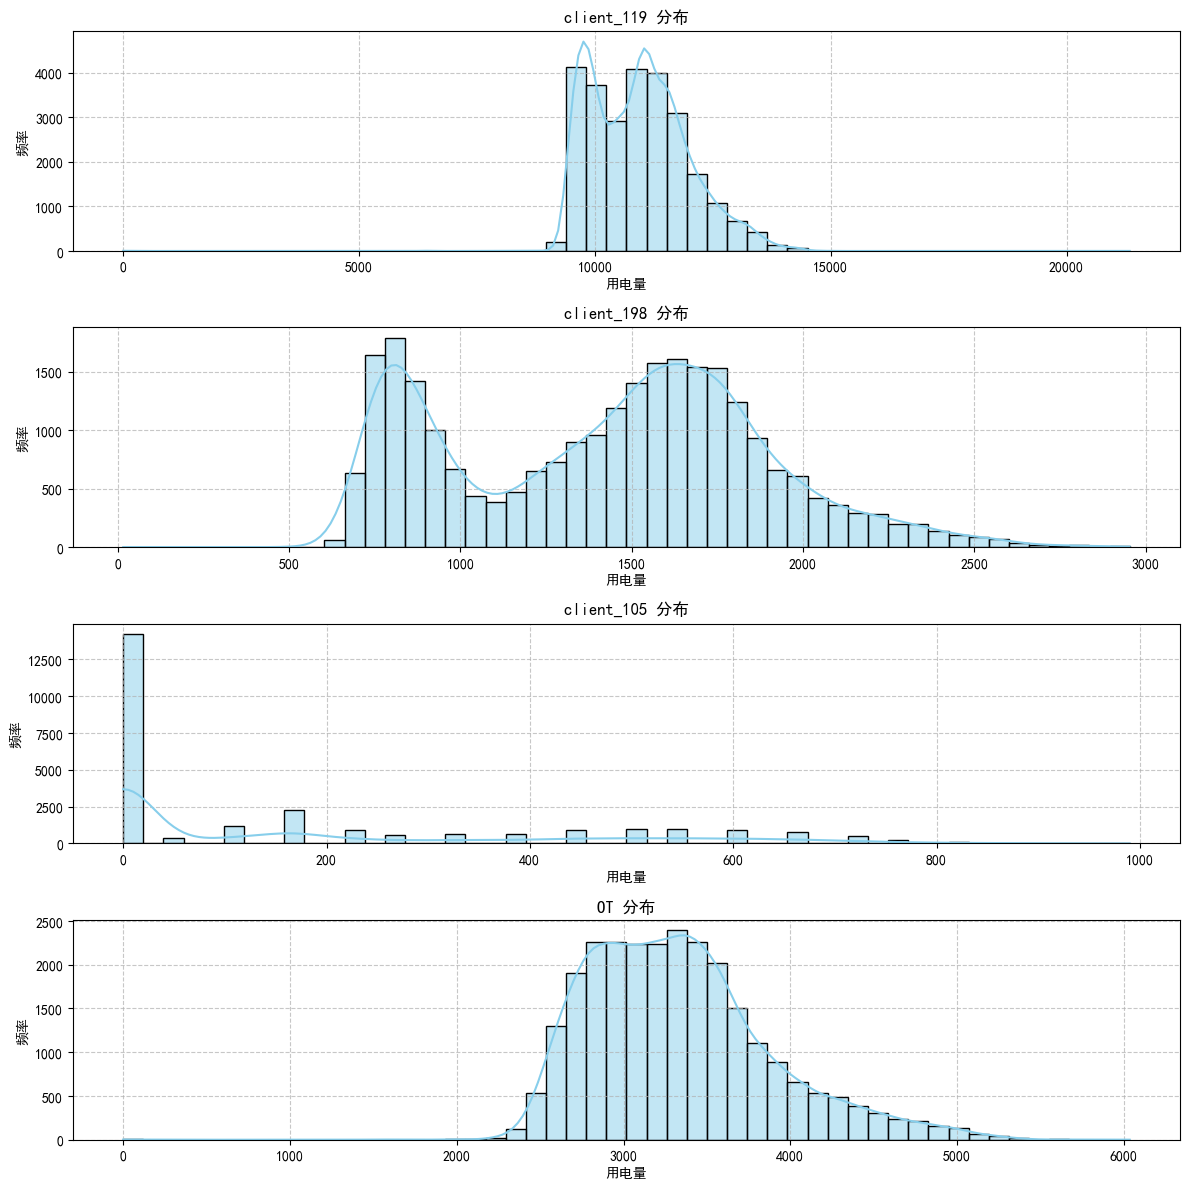

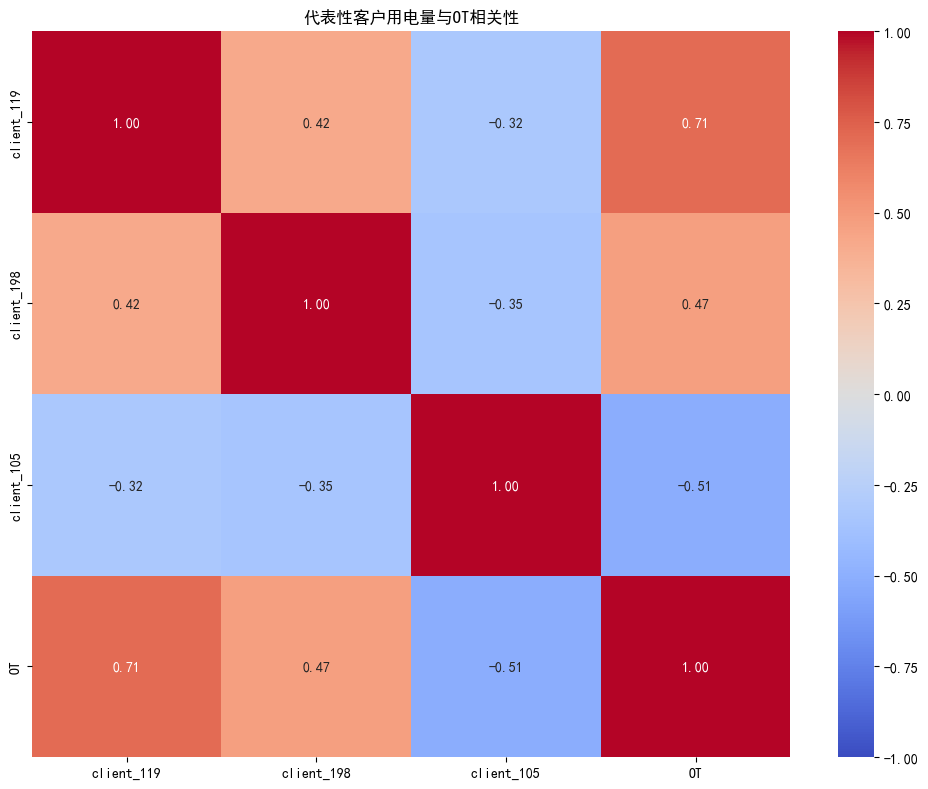

In [25]:
# 2. 探索性分析
# 2. 探索性分析
def exploratory_analysis(df):
    # 基础统计
    print("\n目标变量(OT)统计描述:")
    print(df['OT'].describe())
    
    # 可视化目标变量时间序列
    plt.figure(figsize=(15, 6))
    df['OT'].plot(title='OT (目标变量) 时间序列')
    plt.ylabel('用电量')
    plt.tight_layout()
    plt.savefig('OT_time_series.png')
    plt.show()
    
    # ============= 改进的季节性分解（删除resid部分） =============
    try:
        decomposition = seasonal_decompose(df['OT'].iloc[:1000], period=24)  # 分析前1000小时数据
        
        # 手动创建只包含趋势、季节性和观测值的图表
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 10))
        
        # 观测值
        decomposition.observed.plot(ax=ax1, title='观测值')
        ax1.set_ylabel('用电量')
        
        # 趋势
        decomposition.trend.plot(ax=ax2, title='趋势')
        ax2.set_ylabel('用电量')
        
        # 季节性
        decomposition.seasonal.plot(ax=ax3, title='季节性')
        ax3.set_ylabel('用电量')
        
        plt.tight_layout()
        plt.savefig('seasonal_decomposition.png')
        plt.show()
    except Exception as e:
        print(f"季节性分解错误: {e}")
    
    # ============= 改进的随机用户选择 =============
    # 计算所有客户与OT的相关性
    corr_with_ot = df.drop('OT', axis=1).corrwith(df['OT']).sort_values()
    
    # 选择代表性客户：高相关、中等相关、低相关各选1个
    high_corr_client = corr_with_ot.nlargest(1).index[0]
    med_corr_client = corr_with_ot.index[len(corr_with_ot)//2]  # 取中间位置的客户
    low_corr_client = corr_with_ot.nsmallest(1).index[0]
    
    # 组合代表性客户
    representative_clients = [high_corr_client, med_corr_client, low_corr_client]
    
    print("\n选择的代表性客户:")
    print(f"高相关性客户: {high_corr_client} (相关性: {corr_with_ot[high_corr_client]:.4f})")
    print(f"中等相关性客户: {med_corr_client} (相关性: {corr_with_ot[med_corr_client]:.4f})")
    print(f"低相关性客户: {low_corr_client} (相关性: {corr_with_ot[low_corr_client]:.4f})")
    
    # 绘制代表性客户用电量
    plt.figure(figsize=(15, 10))
    
    for i, client in enumerate(representative_clients, 1):
        plt.subplot(3, 1, i)
        df[client].plot(title=f'{client} 用电量 (与OT相关性: {corr_with_ot[client]:.4f})')
        plt.ylabel('用电量')
        plt.tight_layout()
    
    plt.savefig('representative_client_consumption.png')
    plt.show()
    
   # ============= 按您要求修改的箱线图分析 =============
    # 选择分析对象：代表性客户 + OT
    analysis_columns = representative_clients + ['OT']
    
    # 创建水平箱线图
    plt.figure(figsize=(12, 6))  # 调整高度为6
    
    # 循环绘制每个数值列的箱线图
    for i, column in enumerate(analysis_columns):
        # 计算统计信息
        mean = df[column].mean()
        std = df[column].std()
        min_val = df[column].min()
        q25 = df[column].quantile(0.25)
        median = df[column].median()
        q75 = df[column].quantile(0.75)
        max_val = df[column].max()
        
        # 创建子图
        plt.subplot(len(analysis_columns), 1, i + 1)
        
        # 绘制优化颜色的箱线图
        boxprops = dict(linestyle='-', color='#4287f5', facecolor='#a8c6fa', alpha=0.7)  # 天蓝色箱体
        whiskerprops = dict(linestyle='-', color='#2d6bc9')  # 深蓝色须线
        medianprops = dict(linestyle='-', color='#e63946')  # 红色中位数线
        meanprops = dict(marker='o', markeredgecolor='#2d6bc9', markerfacecolor='#2d6bc9')  # 蓝色均值点
        flierprops = dict(marker='o', markerfacecolor='#4287f5', markersize=6, markeredgecolor='none')  # 天蓝色异常点
        
        plt.boxplot(df[column], vert=False, widths=0.7, patch_artist=True,
                   boxprops=boxprops, whiskerprops=whiskerprops,
                   medianprops=medianprops, meanprops=meanprops,
                   flierprops=flierprops, showmeans=True)
        
        # 添加统计信息到标题
        plt.title(f'{column} 箱线图 ') # | 均值: {mean:.2f} | 中位数: {median:.2f} | 标准差: {std:.2f}
        plt.xlabel('用电量')
        plt.yticks([])
        plt.grid(True, axis='x', linestyle='--', alpha=0.7, color='#cccccc')  # 浅灰色网格线
    
    plt.tight_layout()
    plt.savefig('boxplot_analysis.png')
    plt.show()
    
    # ============= 直方图分析 =============
    plt.figure(figsize=(12, 12))  # 增加高度以适应4个子图
    
    for i, column in enumerate(analysis_columns, 1):
        plt.subplot(len(analysis_columns), 1, i)
        sns.histplot(df[column], bins=50, kde=True, color='skyblue')
        plt.title(f'{column} 分布')
        plt.xlabel('用电量')
        plt.ylabel('频率')
        plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.savefig('histogram_analysis.png')
    plt.show()
    
    # ============= 相关性分析 =============
    plt.figure(figsize=(10, 8))
    corr = df[analysis_columns].corr()
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('代表性客户用电量与OT相关性')
    plt.tight_layout()
    plt.savefig('correlation_heatmap.png')
    plt.show()
# 主程序
if __name__ == "__main__":
    # 加载数据
    file_path = "electricity.csv"  # 根据实际路径修改
    df = load_electricity_data(file_path)
    
    # 探索性分析
    exploratory_analysis(df)
    